In [1]:
import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax
import jax.numpy as np
from jax import random

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_h(N, L, d, n=1, bias=True):
    # Modified from https://github.com/mariogeiger/nn_jamming/blob/master/constN.py
    # TODO: bias=False?
    '''
        For a network with: 
        
        d input dimensionality, 
        L layers, 
        N total parameters, 
        n final outputs,
        
        this finds the corresponding width h 
    '''
    assert L >= 1

    if L == 1:
        # solve : N = h*(d+1) + n*(h+1)
        h = (N - n) / (d + n + 1)
    else:
        # solve : N = h*(d+1) + (L-1)*h*(h+1) + n*(h+1)
        h = -(d+L+n - ((d+L+n)**2 + 4*(L-1)*(N-n))**.5)/(2*(L-1))
    return round(h)

def find_N(h, L, d, n=1):
    return h*(d+1) + (L-1)*h*(h+1) + n*(h+1)

Prepare data

In [3]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
P = 1000 #train
P_total = int(1.25*P)

X = X_raw[:P_total]
y = (2*(y_raw.astype(int) % 2) - 1)[:P_total].reshape(-1,1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1-P/P_total, random_state=42)
len(X_train)

1000

In [6]:
from sklearn.decomposition import PCA
n_components = 20
pca = PCA(n_components = n_components)
pca = pca.fit(X_train)

In [7]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# project to hyper-sphere of radius sqrt(n_components)
X_train = np.sqrt(n_components) * X_train / np.linalg.norm(X_train, axis = 1, keepdims=True)
X_test = np.sqrt(n_components) * X_test / np.linalg.norm(X_test, axis = 1, keepdims=True)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Prepare network

In [8]:
d = n_components
L = 2
N = 20000

h = find_h(N, L, d)
print(h)

130


In [9]:
init_fn, apply_fn, kernel_fn_inf = stax.serial(
    *[stax.Dense(h), stax.Erf()]*L,
    stax.Dense(1)
)

In [10]:
kernelkey = random.PRNGKey(42)
_, init_params = init_fn(kernelkey, X_train.shape)

In [11]:
kernel_fn = nt.empirical_kernel_fn(apply_fn)

In [12]:
gram_ntk = kernel_fn(X_train, X_train, init_params, get='ntk')

In [13]:
eigs = np.linalg.eigvalsh(gram_ntk[:,:, 0, 0])

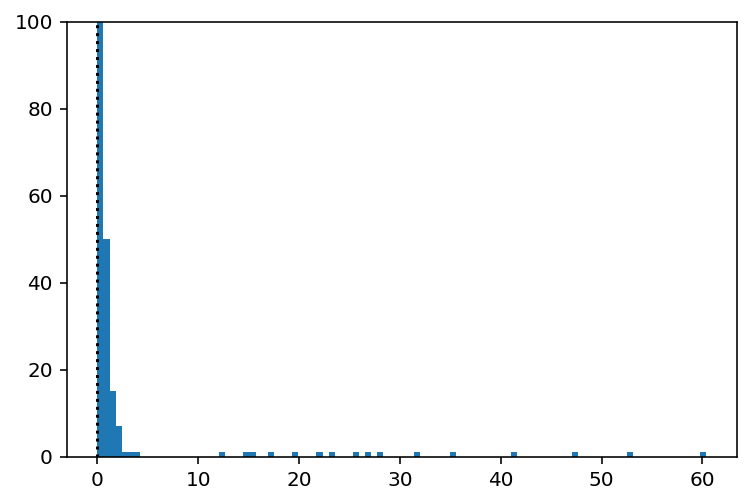

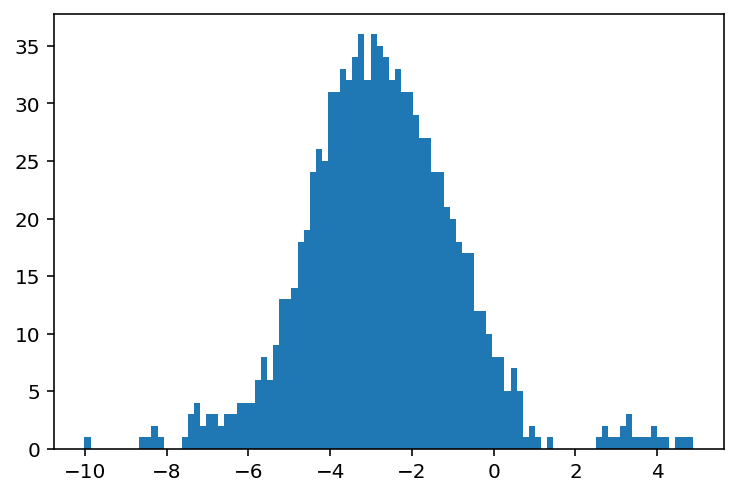

In [14]:
plt.figure()
hist = plt.hist(eigs[:-4], 100)
plt.axvline(0, color='k', linestyle=':')
plt.ylim(0,100)

plt.figure()
loghist = plt.hist(np.log(eigs), 100)

# Do linearized neural networks exhibit jamming?

Fisrt, let's look at the results for network width going to infinity

In [15]:
force = lambda f, y: 1/2 - f*y
loss = lambda fx, y_hat: np.mean(1/2 * np.maximum(0, force(fx, y_hat))**2)

In [16]:
# g_dd = kernel_fn(X_train, X_train, init_params, get='ntk')
# g_td = kernel_fn(X_test, X_train, init_params, get='ntk')

g_dd = kernel_fn_inf(X_train, X_train, get='ntk')
g_td = kernel_fn_inf(X_test, X_train, get='ntk')

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [17]:
predict_fn = nt.predict.gradient_descent(g_dd, y_train, loss, g_td)

In [18]:
train_time = 5e4

fx_train_initial = apply_fn(init_params, X_train)
fx_test_initial = apply_fn(init_params, X_test)

fx_train_final, fx_test_final = predict_fn(
    train_time, 
    fx_train_initial, fx_test_initial
)
train_loss_inf = loss(fx_train_final, y_train)
test_loss_inf = loss(fx_test_final, y_test)

train_loss_inf, test_loss_inf

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


(DeviceArray(6.9839436e-05, dtype=float32),
 DeviceArray(0.02314753, dtype=float32))

In [19]:
print(train_loss_inf)

6.9839436e-05


In [20]:
print(test_loss_inf)

0.023147525


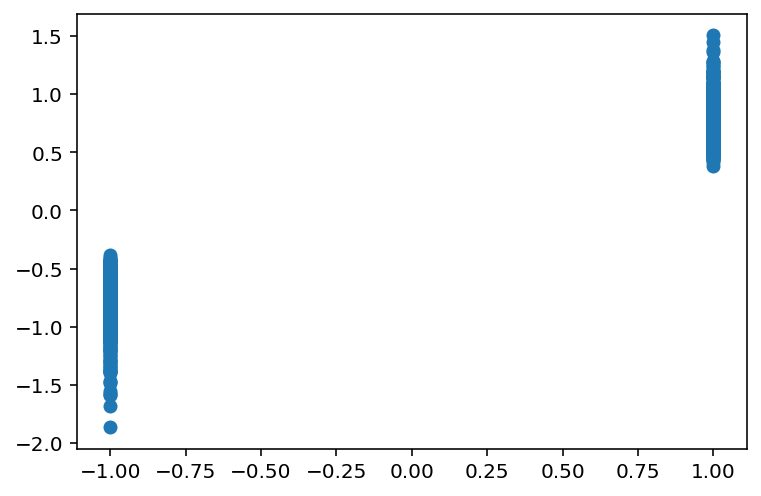

In [21]:
plt.scatter(y_train, fx_train_final)

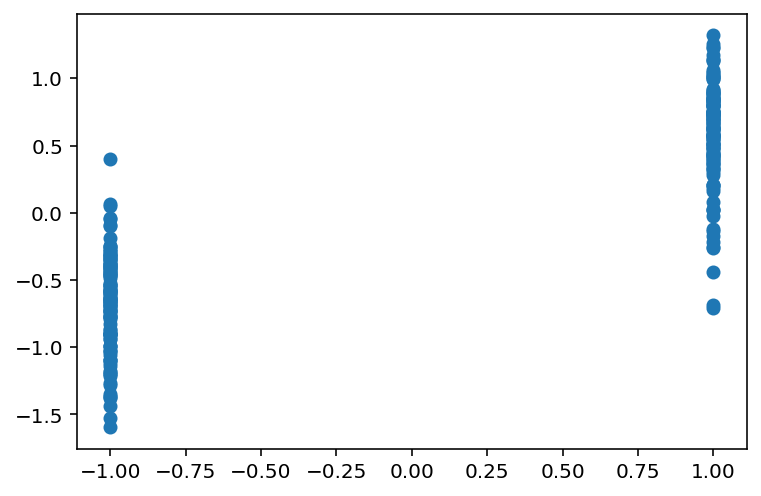

In [22]:
plt.scatter(y_test, fx_test_final)

## Training loop

In [23]:
from tqdm import notebook as tqdm

In [31]:
train_losses = []
test_losses = []
train_forces = []
test_forces = []

Ns = []

for hi in tqdm.trange(h, 0, -1):
    Ni = find_N(hi, L, d)
    Ns.append(Ni)

    init_fn, apply_fn, kernel_fn_inf = stax.serial(
        *[stax.Dense(hi), stax.Erf()]*L,
        stax.Dense(1)
    )
    _, init_params = init_fn(kernelkey, X_train.shape)

    kernel_fn = nt.empirical_kernel_fn(apply_fn)

    g_dd = kernel_fn(X_train, X_train, init_params, get='ntk')
    g_td = kernel_fn(X_test, X_train, init_params, get='ntk')

    predict_fn = nt.predict.gradient_descent(g_dd, y_train, loss, g_td)


    fx_train_initial = apply_fn(init_params, X_train)
    fx_test_initial = apply_fn(init_params, X_test)

    fx_train_final, fx_test_final = predict_fn(
        train_time, 
        fx_train_initial, fx_test_initial
    )
    
    train_loss = loss(fx_train_final, y_train)
    test_loss = loss(fx_test_final, y_test)
    
    train_force = np.ravel(force(fx_train_final, y_train))
    test_force = np.ravel(force(fx_test_final, y_test))

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_forces.append(train_force)
    test_forces.append(test_forces)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Save data

In [33]:
# import pickle
# data = {
#     'train_losses': train_losses,
#     'test_losses': test_losses,
#     'train_forces': train_forces,
#     'test_forces': test_forces,
#     'Ns': Ns,
#     'train_loss_inf': train_loss_inf,
#     'test_loss_inf': test_loss_inf
# }
# pickle.dump(data, open('data.pkl', 'wb'))

Plot

Text(0.5, 1.0, 'Training and testing loss as a function of $N/P$ for an NTK-linearized network')

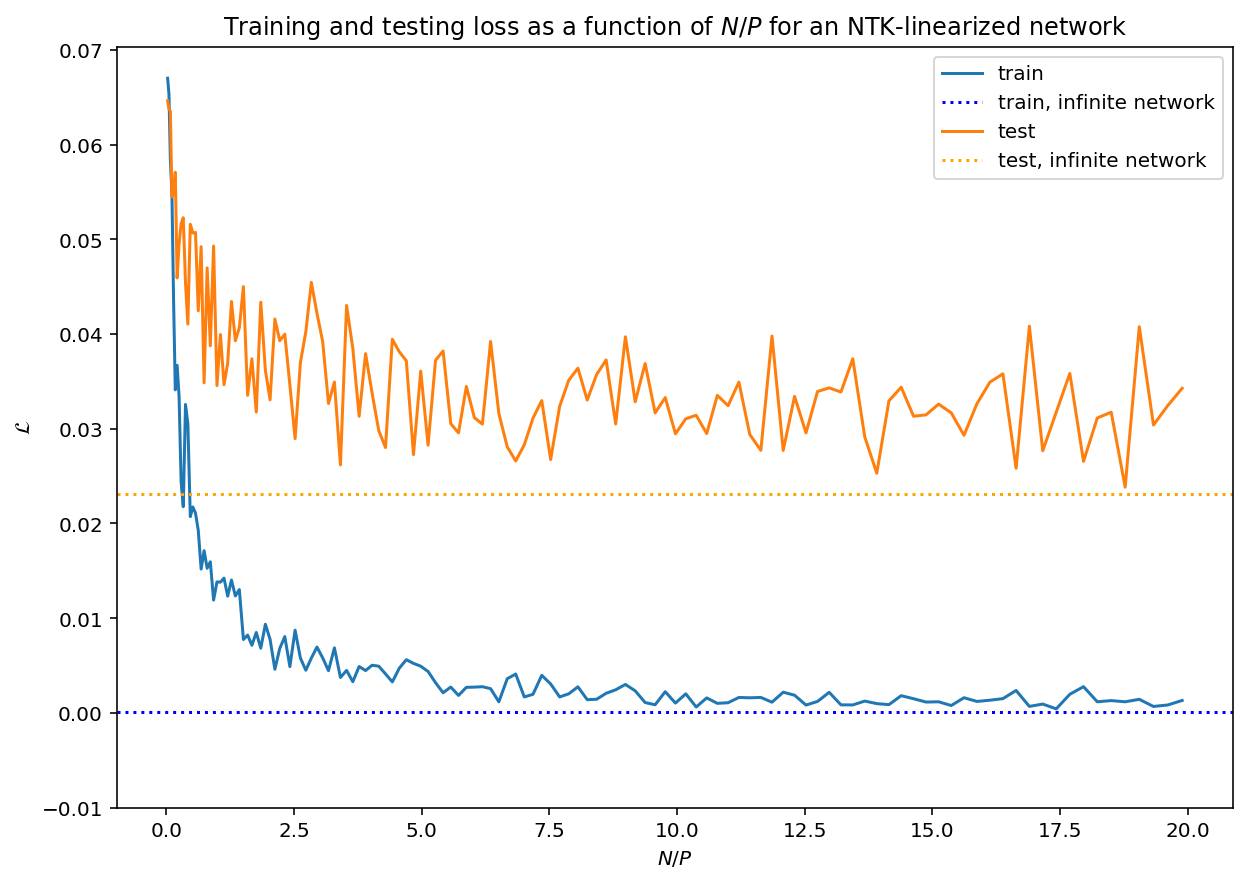

In [41]:
plt.figure(figsize=(10,7))
plt.plot(np.array(Ns)/P, train_losses, label='train')
plt.axhline(train_loss_inf, label='train, infinite network', color='blue', ls=':')
plt.plot(np.array(Ns)/P, test_losses, label='test')
plt.axhline(test_loss_inf, label='test, infinite network', color='orange', ls=':')
plt.ylim(-.01,None)
plt.legend()
plt.xlabel(r'$N/P$')
plt.ylabel(r'$\mathcal{L}$')
plt.title('Training and testing loss as a function of $N/P$ for an NTK-linearized network')

Text(0.5, 1.0, 'Training and testing loss as a function of $N/P$ for an NTK-linearized network')

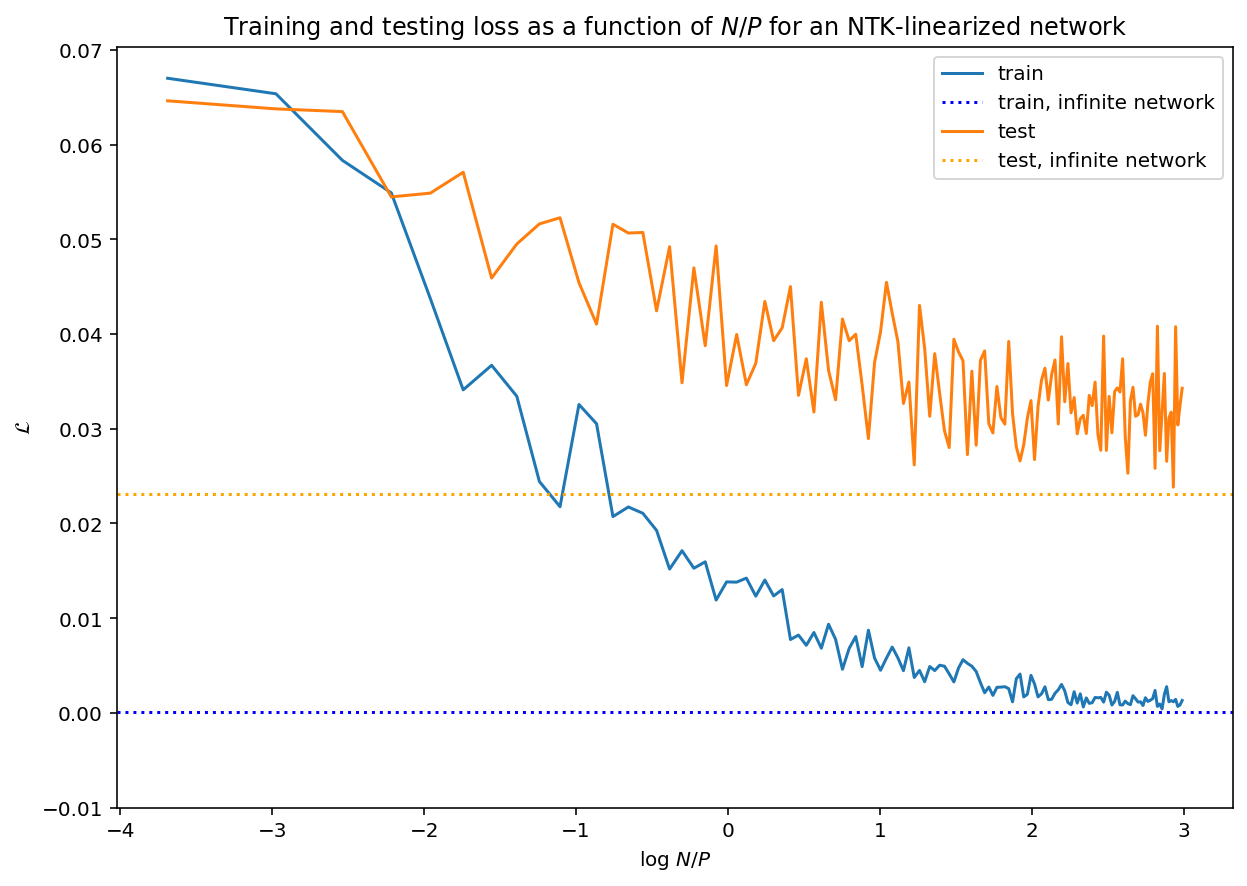

In [90]:
plt.figure(figsize=(10,7))
plt.plot(np.log(np.array(Ns)/P), train_losses, label='train')
plt.axhline(train_loss_inf, label='train, infinite network', color='blue', ls=':')
plt.plot(np.log(np.array(Ns)/P), test_losses, label='test')
plt.axhline(test_loss_inf, label='test, infinite network', color='orange', ls=':')
plt.ylim(-.01,None)
plt.legend()
plt.xlabel(r'log $N/P$')
plt.ylabel(r'$\mathcal{L}$')
plt.title('Training and testing loss as a function of $N/P$ for an NTK-linearized network')

In [56]:
N_dels = []
EPS = 0
for forces in train_forces:
    N_del_i = sum(forces > -EPS)
    N_dels.append(N_del_i)

Text(0, 0.5, '$N_\\Delta/N$')

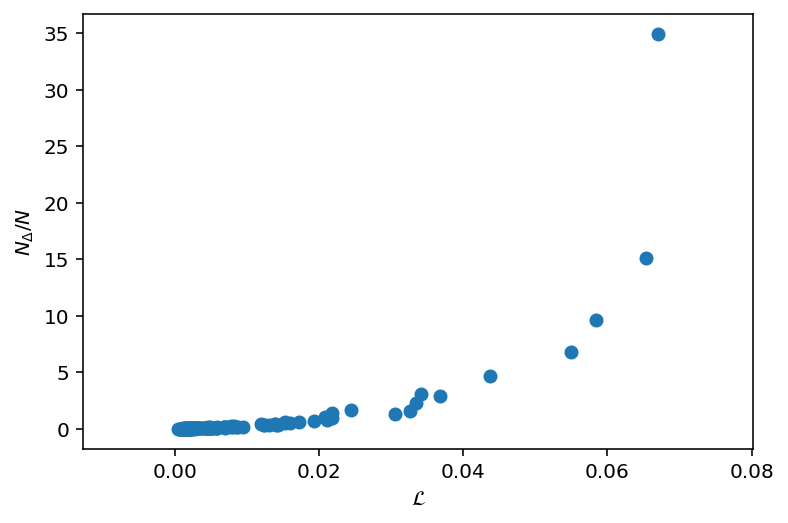

In [86]:
plt.scatter((np.array(train_losses)), (np.array(N_dels)/np.array(Ns)))
plt.xlabel('$\mathcal{L}$')
plt.ylabel('$N_\Delta/N$')
# plt.xlim(0,.08)
# plt.ylim(0,1)


Text(0, 0.5, '$\\log \\ N_\\Delta/N$')

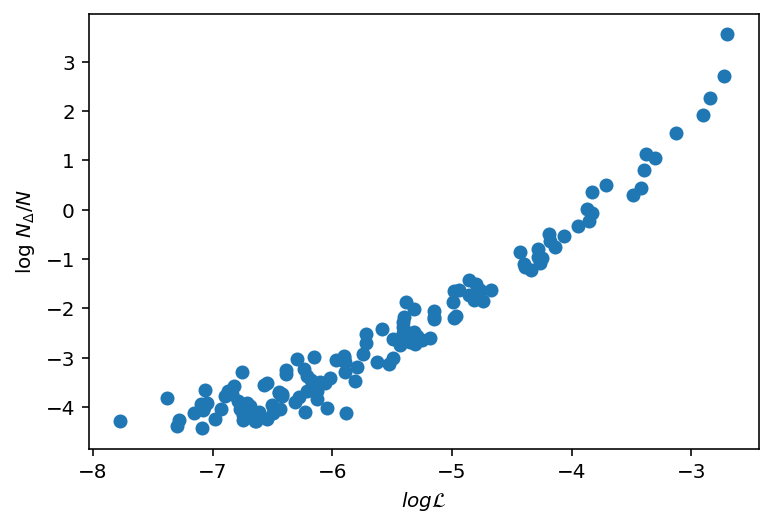

In [84]:
plt.scatter(np.log(np.array(train_losses)), np.log(np.array(N_dels)/np.array(Ns)))
plt.xlabel('$log \mathcal{L}$')
plt.ylabel('$\log \ N_\Delta/N$')
# plt.xlim(0,.08)
# plt.ylim(0,1)


Text(0, 0.5, '$log  N_\\Delta/N$')

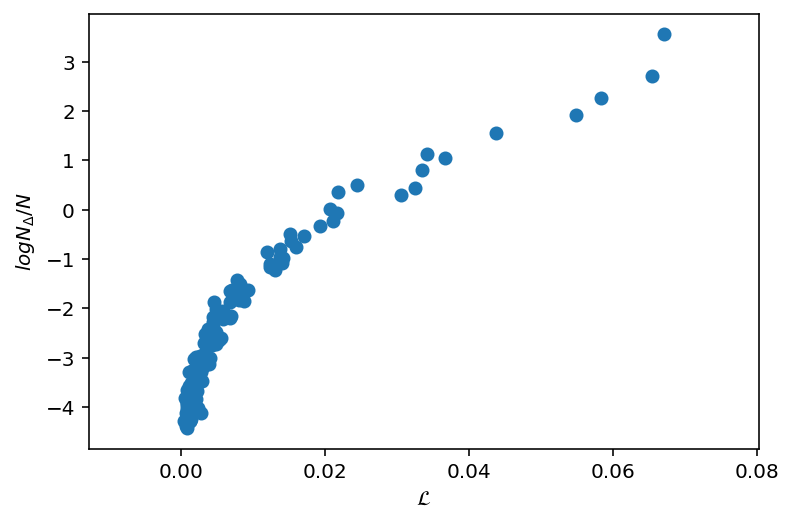

In [89]:
plt.scatter((train_losses), np.log(np.array(N_dels)/np.array(Ns)))
plt.xlabel('$\mathcal{L}$')
plt.ylabel('$log  N_\Delta/N$')
# plt.xlim(0,.08)
# plt.ylim(0,1)


Text(0, 0.5, '$N_\\Delta/N$')

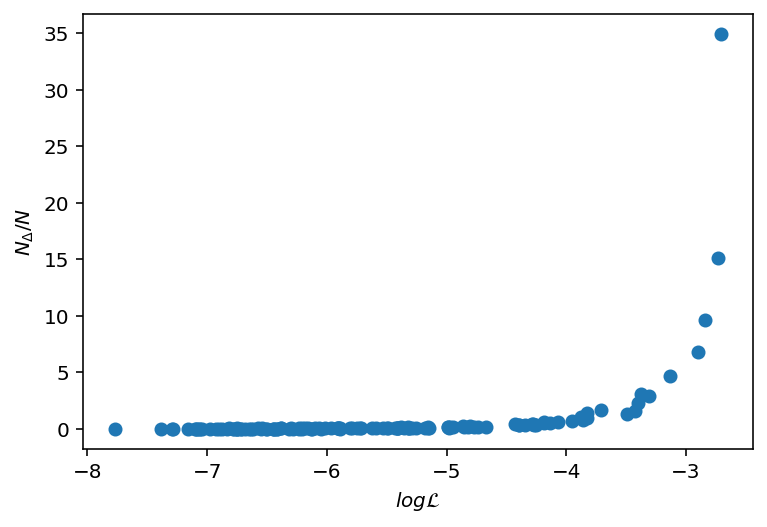

In [93]:
plt.scatter(np.log(np.array(train_losses)), (np.array(N_dels)/np.array(Ns)))
plt.xlabel('$log \mathcal{L}$')
plt.ylabel('$N_\Delta/N$')
# plt.xlim(0,.08)
# plt.ylim(0,1)


Text(0, 0.5, '$N_\\Delta/N$')

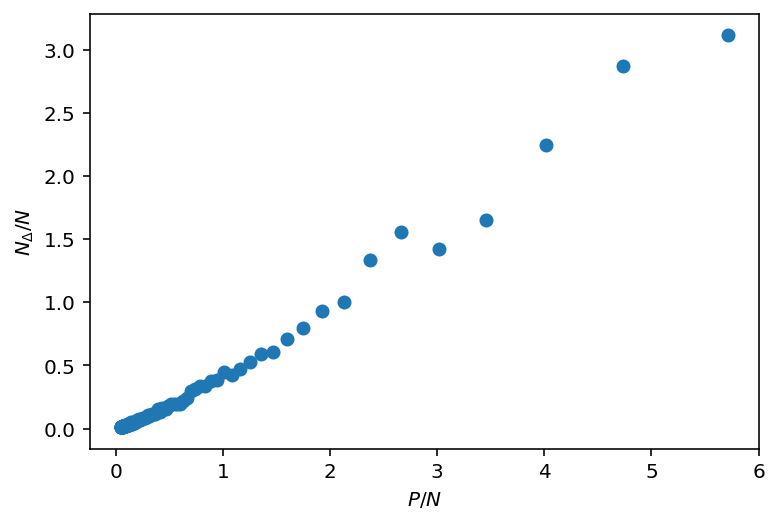

In [80]:
plt.scatter((P/np.array(Ns))[:-5], (np.array(N_dels)/np.array(Ns))[:-5])
plt.xlabel('$P/N$')
plt.ylabel('$N_\Delta/N$')